In [12]:
import glob
import os
import sys
import time
import uuid
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person

In [3]:
KEY = os.environ['COGNITIVE_SERVICE_KEY']
ENDPOINT = os.environ['ENDPOINT'] 

In [4]:
# Create an authenticated FaceClient.
face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

In [5]:
# Used in the Person Group Operations,  Snapshot Operations, and Delete Person Group examples.
# You can call list_person_groups to print a list of preexisting PersonGroups.
# SOURCE_PERSON_GROUP_ID should be all lowercase and alphanumeric. For example, 'mygroupname' (dashes are OK).
PERSON_GROUP_ID = 'imm_high_03'

# Used for the Snapshot and Delete Person Group examples.
TARGET_PERSON_GROUP_ID = str(uuid.uuid4()) # assign a random ID (or name it anything)

In [6]:
train_path = 'imm/train_high/'
ids = set([x.split('-')[0] for x in os.listdir(train_path)])
ids = list(ids)
ids.sort()

In [7]:
'''
Create the PersonGroup
'''
# Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
print('Person group:', PERSON_GROUP_ID)
face_client.person_group.create(person_group_id=PERSON_GROUP_ID, name=PERSON_GROUP_ID)

people = []
index_dict = []
for index in ids:
    person = face_client.person_group_person.create(PERSON_GROUP_ID, index)
    people.append(person)
    index_dict.extend([{'index': index, 'person_id': person.person_id}])


Person group: imm_high_03


In [8]:
'''
Detect faces and register to correct person
'''
# Find all jpeg images of person in working directory
people_images = []
for index in ids:
    person_images = [train_path + file for file in os.listdir(train_path) if file.startswith(index)]
    people_images.append(person_images)

for person, person_images in zip(people, people_images):
    # Add to a woman person
    for image in person_images:
        w = open(image, 'r+b')
        face_client.person_group_person.add_face_from_stream(PERSON_GROUP_ID, person.person_id, w)


In [9]:
'''
Train PersonGroup
'''
print()
print('Training the person group...')
# Train the person group
face_client.person_group.train(PERSON_GROUP_ID)

while (True):
    training_status = face_client.person_group.get_training_status(PERSON_GROUP_ID)
    print("Training status: {}.".format(training_status.status))
    print()
    if (training_status.status is TrainingStatusType.succeeded):
        break
    elif (training_status.status is TrainingStatusType.failed):
        sys.exit('Training the person group has failed.')
    time.sleep(5)


Training the person group...
Training status: running.

Training status: succeeded.



In [18]:
'''
Identify a face against a defined PersonGroup
'''
TEST_FOLDER = 'imm/test/'
test_images = os.listdir(TEST_FOLDER)
test_images.sort()
confidence_values = []
count = 0
for test_image in test_images:
    # Get test image
    test_image_array = glob.glob(os.path.join(TEST_FOLDER, test_image))
    image = open(test_image_array[0], 'r+b')

    # Detect faces
    face_ids = []
    faces = face_client.face.detect_with_stream(image)
    for face in faces:
        face_ids.append(face.face_id)

    # Identify faces
    results = face_client.face.identify(face_ids, PERSON_GROUP_ID)
    print('Identifying faces in {}'.format(os.path.basename(image.name)))
    if not results:
        count += 1
        print('No person identified in the person group for faces from {}.'.format(os.path.basename(image.name)))
    else:
        for person in results:
            if not person.candidates:
                count += 1
                print('Cannot identify this identity')
                confidence_values.append(0)
            else:
                index_person = [d['index'] for d in index_dict if d['person_id']== person.candidates[0].person_id]
                if index_person[0] == os.path.basename(image.name).split('-')[0]:
                    print('Succesfull identifed with confidence: ', person.candidates[0].confidence)
                    confidence_values.append(person.candidates[0].confidence)
                else:
                    count +=1
                    print('Identify wrong person')
                    confidence_values.append(0)
print('Percentage of un-identified images: ', count/len(test_images))

Identifying faces in 01-6m.jpg
Cannot identify this identity
Identifying faces in 02-6m.jpg
Succesfull identifed with confidence:  0.57943
Identifying faces in 03-6m.jpg
Succesfull identifed with confidence:  0.5572
Identifying faces in 04-6m.jpg
Cannot identify this identity
Identifying faces in 05-6m.jpg
Succesfull identifed with confidence:  0.55493
Identifying faces in 06-6m.jpg
Succesfull identifed with confidence:  0.53334
Identifying faces in 07-6m.jpg
Succesfull identifed with confidence:  0.52002
Identifying faces in 08-6f.jpg
Succesfull identifed with confidence:  0.59682
Identifying faces in 09-6m.jpg
Succesfull identifed with confidence:  0.56001
Identifying faces in 10-6m.jpg
Succesfull identifed with confidence:  0.59454
Identifying faces in 11-6m.jpg
Succesfull identifed with confidence:  0.58828
Identifying faces in 12-6f.jpg
Cannot identify this identity
Identifying faces in 13-6m.jpg
Cannot identify this identity
Identifying faces in 14-6f.jpg
Cannot identify this ide

In [19]:
confidence_values

[0,
 0.57943,
 0.5572,
 0,
 0.55493,
 0.53334,
 0.52002,
 0.59682,
 0.56001,
 0.59454,
 0.58828,
 0,
 0,
 0,
 0,
 0,
 0,
 0.63938,
 0.54023,
 0.5264,
 0,
 0,
 0,
 0,
 0,
 0.57417,
 0,
 0.51044,
 0.55832,
 0.59454,
 0,
 0.5228,
 0.5324,
 0.55286,
 0,
 0.58507,
 0,
 0,
 0,
 0.52671]

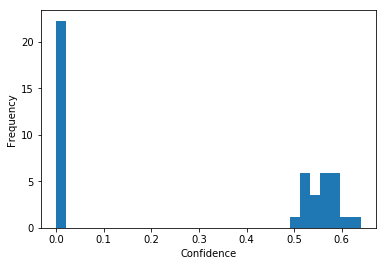

In [22]:
plt.hist(confidence_values, density=True, bins=30)  # `density=False` would make counts
plt.ylabel('Frequency')
plt.xlabel('Confidence')
plt.savefig('confidence_hist_high.png')